<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B8%A5%E0%B9%88%E0%B8%B2%E0%B8%AA%E0%B8%B8%E0%B8%94%E0%B8%88%E0%B8%A3%E0%B8%B4%E0%B8%87_Keras_efficientnet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [82]:
!sudo update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.7   2         auto mode
* 1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1


In [83]:
!apt-get install python3-pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [84]:
!python3 -m pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters

In [87]:
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone **efficientnet** repo

In [88]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [89]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [90]:
#!pip install tf-nightly

In [91]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 75, 75, 32)  128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                    

## Download and extract `dog_vs_cat` dataset

In [ ]:
#https://drive.google.com/drive/folders/1he-7wku7JhK5qUKw90h46FHSZTDJSu8X?usp=sharing

In [97]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/dog_vs_cat'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [98]:
path = '/content/drive/My Drive/dog_vs_cat'

In [ ]:
#if not os.path.isfile("kagglecatsanddogs_5340.zip"):
 #!wget /content/kagglecatsanddogs_5340.zip
 #!unzip -qq /content/kagglecatsanddogs_5340.zip -d dog_vs_cat
#else:
 # print("dataset already exist.")

In [99]:
data_file_path = os.path.join(path,'/content/drive/My Drive/dog_vs_cat/data')   

In [ ]:
#@title เพิ่มมา แต่หาไม่ access 
#!ls /content/drive/My Drive/dog_vs_cat/PetImages
#!ls /content/drive/My Drive/dog_vs_cat/PetImages/Cat -l -t | head -10

In [ ]:
#@title ต้นฉบับ แต่หาไม่ access 
#!ls dog_vs_cat/PetImages/
#!ls dog_vs_cat/PetImages/Cat -l -t | head -10

In [100]:
#@title ข้อความอธิบายภาพเริ่มต้น
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/drive/My Drive/dog_vs_cat/data'

cat_images = glob.glob(os.path.join(original_dataset_dir, "cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 51
total dog images: 51


In [93]:
#@title ต้นฉบับ
# The path to the directory where the original
# dataset was uncompressed
#original_dataset_dir = './dog_vs_cat/PetImages'

#cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
#dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
#print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

In [101]:
# The directory where we will
# store our smaller dataset
base_dir = '/content/drive/MyDrive/dog_vs_cat/data'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [102]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 114
total training dog images: 101
total validation cat images: 15
total validation dog images: 15
total test cat images: 15
total test dog images: 21


In [ ]:
validation_cats_dir

'/content/drive/MyDrive/dog_vs_cat/data/validation/cats'

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 215 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [104]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [105]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [106]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [109]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20


AttributeError: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [ ]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
42/42 [==============================] - 18s 424ms/step - loss: 1.1131 - acc: 0.6610 - val_loss: 0.7262 - val_acc: 0.7360
Epoch 2/20
42/42 [==============================] - 16s 377ms/step - loss: 1.1714 - acc: 0.6570 - val_loss: 0.7053 - val_acc: 0.7420
Epoch 3/20
42/42 [==============================] - 16s 380ms/step - loss: 1.0955 - acc: 0.6690 - val_loss: 0.6855 - val_acc: 0.7520
Epoch 4/20
42/42 [==============================] - 16s 377ms/step - loss: 1.0311 - acc: 0.6660 - val_loss: 0.6783 - val_acc: 0.7530
Epoch 5/20
42/42 [==============================] - 16s 374ms/step - loss: 1.0248 - acc: 0.6850 - val_loss: 0.6653 - val_acc: 0.7590
Epoch 6/20
42/42 [==============================] - 16s 374ms/step - loss: 0.9756 - acc: 0.6945 - val_loss: 0.6460 - val_acc: 0.7650
Epoch 7/20
42/42 [==============================] - 16s 374ms/step - loss: 1.0248 - acc: 0.6880 - val_loss: 0.6377 - val_acc: 0.7700
Epoch 8/20
42/42 [==============================] - 16s 376ms/step - 

In [ ]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

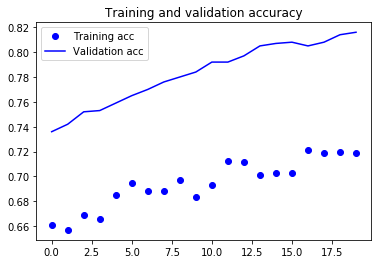

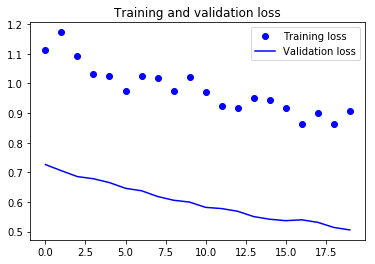

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [ ]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

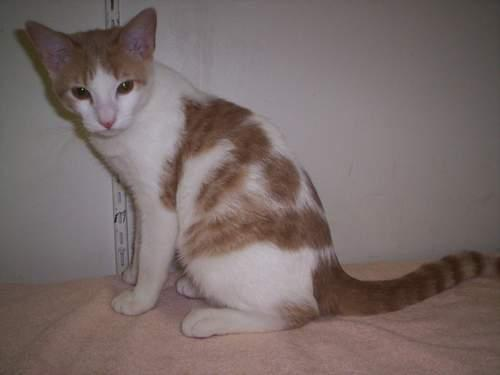

In [ ]:
Image(filename=cat_img)

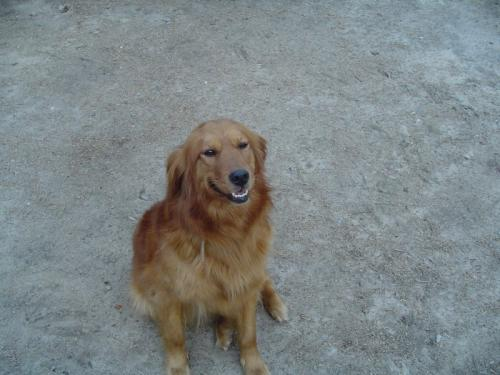

In [ ]:
Image(filename=dog_img)

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.9974619)
('dog', 0.9999910624692347)


## Download the model

In [ ]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

In [ ]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [ ]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")